In [1]:
!head data/122020.json

head: data/122020.json: No such file or directory


In [2]:
import pyspark as ps 
import pandas as pd 
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality = 100)
%matplotlib inline



spark = ps.sql.SparkSession.builder \
    .master("local[4]") \
    .appName("Preprocessing") \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
spark 

In [4]:
sc

<SparkContext master=local[4] appName=Preprocessing>

In [5]:
my_df1 = spark.read.json('data/122020.json.gz')

In [6]:
my_df1.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- backers_count: long (nullable = true)
 |    |-- blurb: string (nullable = true)
 |    |-- category: struct (nullable = true)
 |    |    |-- color: long (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- parent_id: long (nullable = true)
 |    |    |-- parent_name: string (nullable = true)
 |    |    |-- position: long (nullable = true)
 |    |    |-- slug: string (nullable = true)
 |    |    |-- urls: struct (nullable = true)
 |    |    |    |-- web: struct (nullable = true)
 |    |    |    |    |-- discover: string (nullable = true)
 |    |-- converted_pledged_amount: long (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- country_displayable_name: string (nullable = true)
 |    |-- created_at: long (nullable = true)
 |    |-- creator: struct (nullable = true)
 |    |    |-- avatar: struct (nullable = true)
 |    |    |    |-- medium: string (nu

In [7]:
my_df1.createOrReplaceTempView('my_df')

In [8]:
US_results = spark.sql("SELECT data.id, data.name, data.country, data.backers_count, data.currency, data.deadline, data.goal, data.launched_at, data.pledged, data.state AS project_state,  data.category.parent_name AS category, data.category.name AS sub_category,data.spotlight FROM my_df WHERE data.country == 'US' ")


In [9]:
US_results.show()

+----------+--------------------+-------+-------------+--------+----------+--------+-----------+-------+-------------+-----------+----------------+---------+
|        id|                name|country|backers_count|currency|  deadline|    goal|launched_at|pledged|project_state|   category|    sub_category|spotlight|
+----------+--------------------+-------+-------------+--------+----------+--------+-----------+-------+-------------+-----------+----------------+---------+
|1124922936| Palmetto Pork Skins|     US|            1|     USD|1453922267| 25000.0| 1451330267|   50.0|       failed|       Food|     Food Trucks|    false|
|2077771673|Eat Shit: A Memor...|     US|           11|     USD|1575075016|   250.0| 1572479416|  253.0|   successful|    Fashion|     Accessories|     true|
|2008689997|   TRIC Clothing Co.|     US|           50|     USD|1604171238|  4000.0| 1601579238| 4475.0|   successful|    Fashion|         Apparel|     true|
| 409339132|          Vindictive|     US|           

In [10]:
df = US_results.toPandas()

In [11]:
df['duration'] = (df['deadline'] - df['launched_at']) / 86400
df['fr'] = df['pledged'] / df['goal']
df

,id,name,country,backers_count,currency,deadline,goal,launched_at,pledged,project_state,category,sub_category,spotlight,duration,fr
0,1124922936,Palmetto Pork Skins,US,1,USD,1453922267,25000.0,1451330267,50.00,failed,Food,Food Trucks,False,30.000000,0.002000
1,2077771673,Eat Shit: A Memorial Pin Campaign,US,11,USD,1575075016,250.0,1572479416,253.00,successful,Fashion,Accessories,True,30.041667,1.012000
2,2008689997,TRIC Clothing Co.,US,50,USD,1604171238,4000.0,1601579238,4475.00,successful,Fashion,Apparel,True,30.000000,1.118750
3,409339132,Vindictive,US,2,USD,1472663760,600.0,1471054707,662.00,successful,Comics,Graphic Novels,True,18.623299,1.103333
4,1789057014,Wooden HEZ's Southern HEZpitality Tour 2013,US,10,USD,1365875128,600.0,1363283128,601.43,successful,Music,Rock,True,30.000000,1.002383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147895,1418520966,NASCAR at the Valentine Richmond History Center,US,21,USD,1399825596,1000.0,1394641596,1201.00,successful,Art,Public Art,True,60.000000,1.201000
147896,1566394390,"""Wizard Alchemy"" Poetry Gazette from Word Wiza...",US,0,USD,1448938926,88489.0,1446343326,0.00,failed,Publishing,Poetry,False,30.041667,0.000000
147897,2119955004,THE COLD SEASON,US,2,USD,1610548826,1500.0,1607956826,21.00,live,Film & Video,Drama,False,30.000000,0.014000
147898,1438234172,Adventures of a Lost Poet,US,1,USD,1500140227,500.0,1496252227,10.00,failed,Publishing,Poetry,False,45.000000,0.020000


# Now we have our dataset for US in pandas form. Checking for missing values

In [136]:
df_s.isnull().sum().sum()


0

In [137]:
df_f.isnull().sum().sum()


0

## Project State graph

In [12]:
state_grouped = df.groupby('project_state')['project_state'].count()
state_grouped

project_state
canceled       6117
failed        51476
live           2622
successful    87685
Name: project_state, dtype: int64

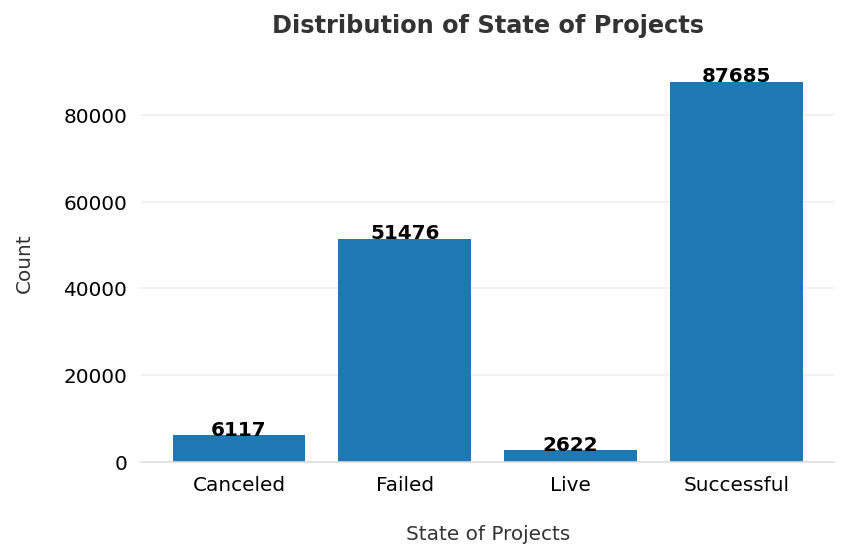

In [13]:
x = ['Canceled', 'Failed', 'Live', 'Successful']
y = [6117, 51476, 2622, 87685]
fig, ax = plt.subplots()

bars = ax.bar(
    x = x,
    height = y,
    tick_label = x
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

ax.tick_params(bottom = False, left = False)

ax.set_axisbelow(True)
ax.yaxis.grid(True, color = '#EEEEEE')
ax.xaxis.grid(False)

for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.3,
        round(bar.get_height(), 1),
        horizontalalignment = 'center',
        color = 'black',
        weight = 'bold'
    )


ax.set_xlabel('State of Projects', labelpad=15, color = '#333333')
ax.set_ylabel('Count', labelpad=15, color = '#333333')
ax.set_title('Distribution of State of Projects', pad = 15, color = '#333333', weight = 'bold')


fig.tight_layout()

## Success vs fail

In [14]:
df_s = df[df['project_state'] == 'successful']
df_f = df[df['project_state'] == 'failed']

In [15]:
len(df_s)

87685

In [16]:
len(df_f)

51476

Backercount 

In [17]:
df_s.backers_count.mean()

270.1600159662428

In [18]:
df_f.backers_count.mean()

11.88513093480457

goal avg

In [19]:
df_s.goal.mean()

9444.67728117694

In [20]:
df_f.goal.mean()

82809.1529141736

pledged avg

In [21]:
df_s.pledged.mean()

25990.123484518444

In [22]:
df_f.pledged.mean()

1060.6282350998515

avg duration 

In [23]:
df_s.duration.mean()

31.051258625546172

In [24]:
df_f.duration.mean()

35.333831778266756

# Category and Sub_category analysis 

## Success 

In [25]:
cat_s = df_s.groupby('category')['category'].count().reset_index(name="count")
total_s = cat_s['count'].sum()
cat_s['percent'] = cat_s['count']/total_s * 100
cat_s = cat_s.sort_values(by = 'percent')
cat_s

,category,count,percent
2,Crafts,939,1.125913
9,Journalism,1112,1.333349
3,Dance,1642,1.968849
11,Photography,2465,2.955671
14,Theater,2820,3.381336
4,Design,3154,3.781820
7,Food,4560,5.467691
5,Fashion,4812,5.769853
8,Games,5496,6.590007
1,Comics,5732,6.872984


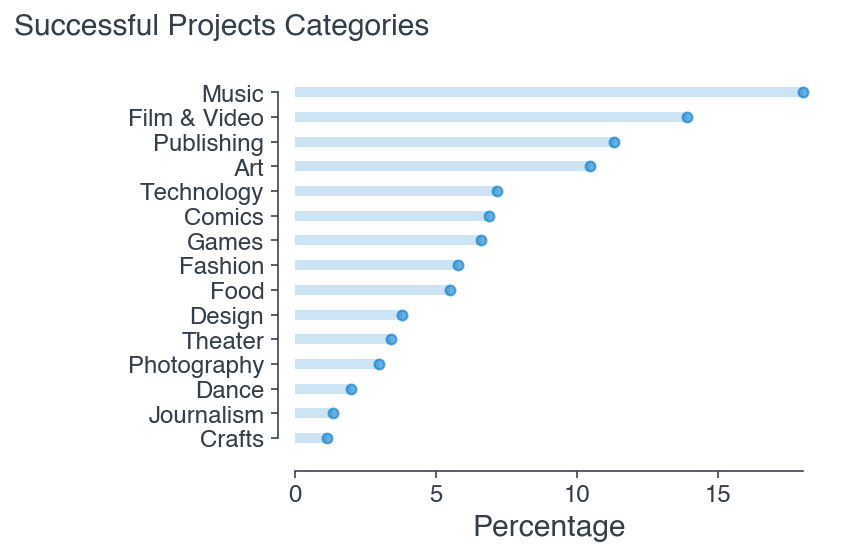

In [26]:



plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

my_range=list(range(1,len(cat_s.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))


plt.hlines(y=my_range, xmin=0, xmax=cat_s['percent'], color='#007ACC', alpha=0.2, linewidth=5)

plt.plot(cat_s['percent'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)


ax.set_xlabel('Percentage', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, cat_s.category)

fig.text(-0.23, 0.96, 'Successful Projects Categories', fontsize=15, fontweight='black', color = '#333F4B')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

ax.spines['bottom'].set_position(('axes', -0.04))
ax.spines['left'].set_position(('axes', 0.015))



In [27]:
df_f.groupby('category')[['backers_count','goal','pledged','duration']].mean()

,backers_count,goal,pledged,duration
category,,,,
Art,8.121556,52686.645215,576.056591,34.630584
Comics,30.437601,19526.777958,1492.792577,35.285816
Crafts,5.381974,14135.252048,354.578607,32.803312
Dance,8.087500,16153.364583,514.044688,33.706926
Design,17.163011,123595.305276,1385.380053,33.423519
Fashion,9.890226,25170.647569,903.378926,33.676055
Film & Video,14.208926,234508.868506,1480.598223,36.019167
Food,11.674591,52579.848845,992.955222,35.882713
Games,15.857704,106344.745339,1229.670702,34.561504


## Failed

In [28]:
cat_f = df_f.groupby('category')['category'].count().reset_index(name="count")
total_f = cat_f['count'].sum()
cat_f['percent'] = cat_f['count']/total_f * 100
cat_f = cat_f.sort_values(by = 'percent')
cat_f

,category,count,percent
3,Dance,480,0.934616
1,Comics,617,1.201371
14,Theater,1224,2.383270
4,Design,1687,3.284785
8,Games,2038,3.968223
5,Fashion,2077,4.044161
11,Photography,2250,4.381012
9,Journalism,2303,4.484209
2,Crafts,2563,4.990459
12,Publishing,3786,7.371782


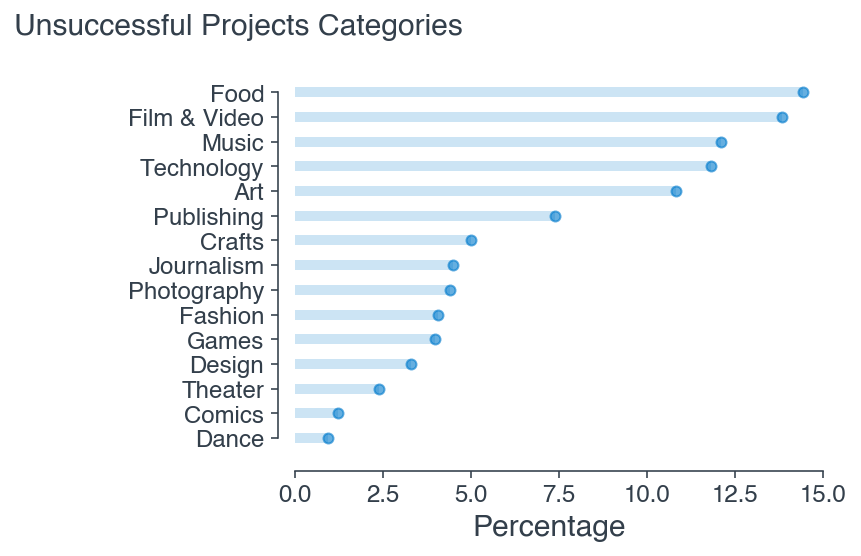

In [29]:

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

my_range=list(range(1,len(cat_f.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))


plt.hlines(y=my_range, xmin=0, xmax=cat_f['percent'], color='#007ACC', alpha=0.2, linewidth=5)

plt.plot(cat_f['percent'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

ax.set_xlabel('Percentage', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, cat_f.category)

fig.text(-0.23, 0.96, 'Unsuccessful Projects Categories', fontsize=15, fontweight='black', color = '#333F4B')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

ax.spines['bottom'].set_position(('axes', -0.04))
ax.spines['left'].set_position(('axes', 0.015))


# Duration/Category Box Plot 

In [30]:
duration_f = df_f[['duration','category']]
duration_s = df_s[['duration','category']]

duration_s

,duration,category
1,30.041667,Fashion
2,30.000000,Fashion
3,18.623299,Comics
4,30.000000,Music
5,29.116458,Crafts
...,...,...
147890,30.000000,Fashion
147892,58.000000,Technology
147893,30.000000,Theater
147895,60.000000,Art


In [31]:
f = duration_f.groupby('category').mean().reset_index()

In [32]:
s =duration_s.groupby('category').mean().reset_index()

In [33]:
f = f.rename(columns={"duration":"duration_f"})
s= s.rename(columns={"duration":"duration_s"})

In [34]:
cd_df = pd.merge(f,s,on = 'category')
cd_df

,category,duration_f,duration_s
0,Art,34.630584,29.859296
1,Comics,35.285816,29.453357
2,Crafts,32.803312,28.979617
3,Dance,33.706926,30.139093
4,Design,33.423519,32.004677
5,Fashion,33.676055,29.111934
6,Film & Video,36.019167,31.424867
7,Food,35.882713,31.672057
8,Games,34.561504,28.530466
9,Journalism,35.126834,31.652741


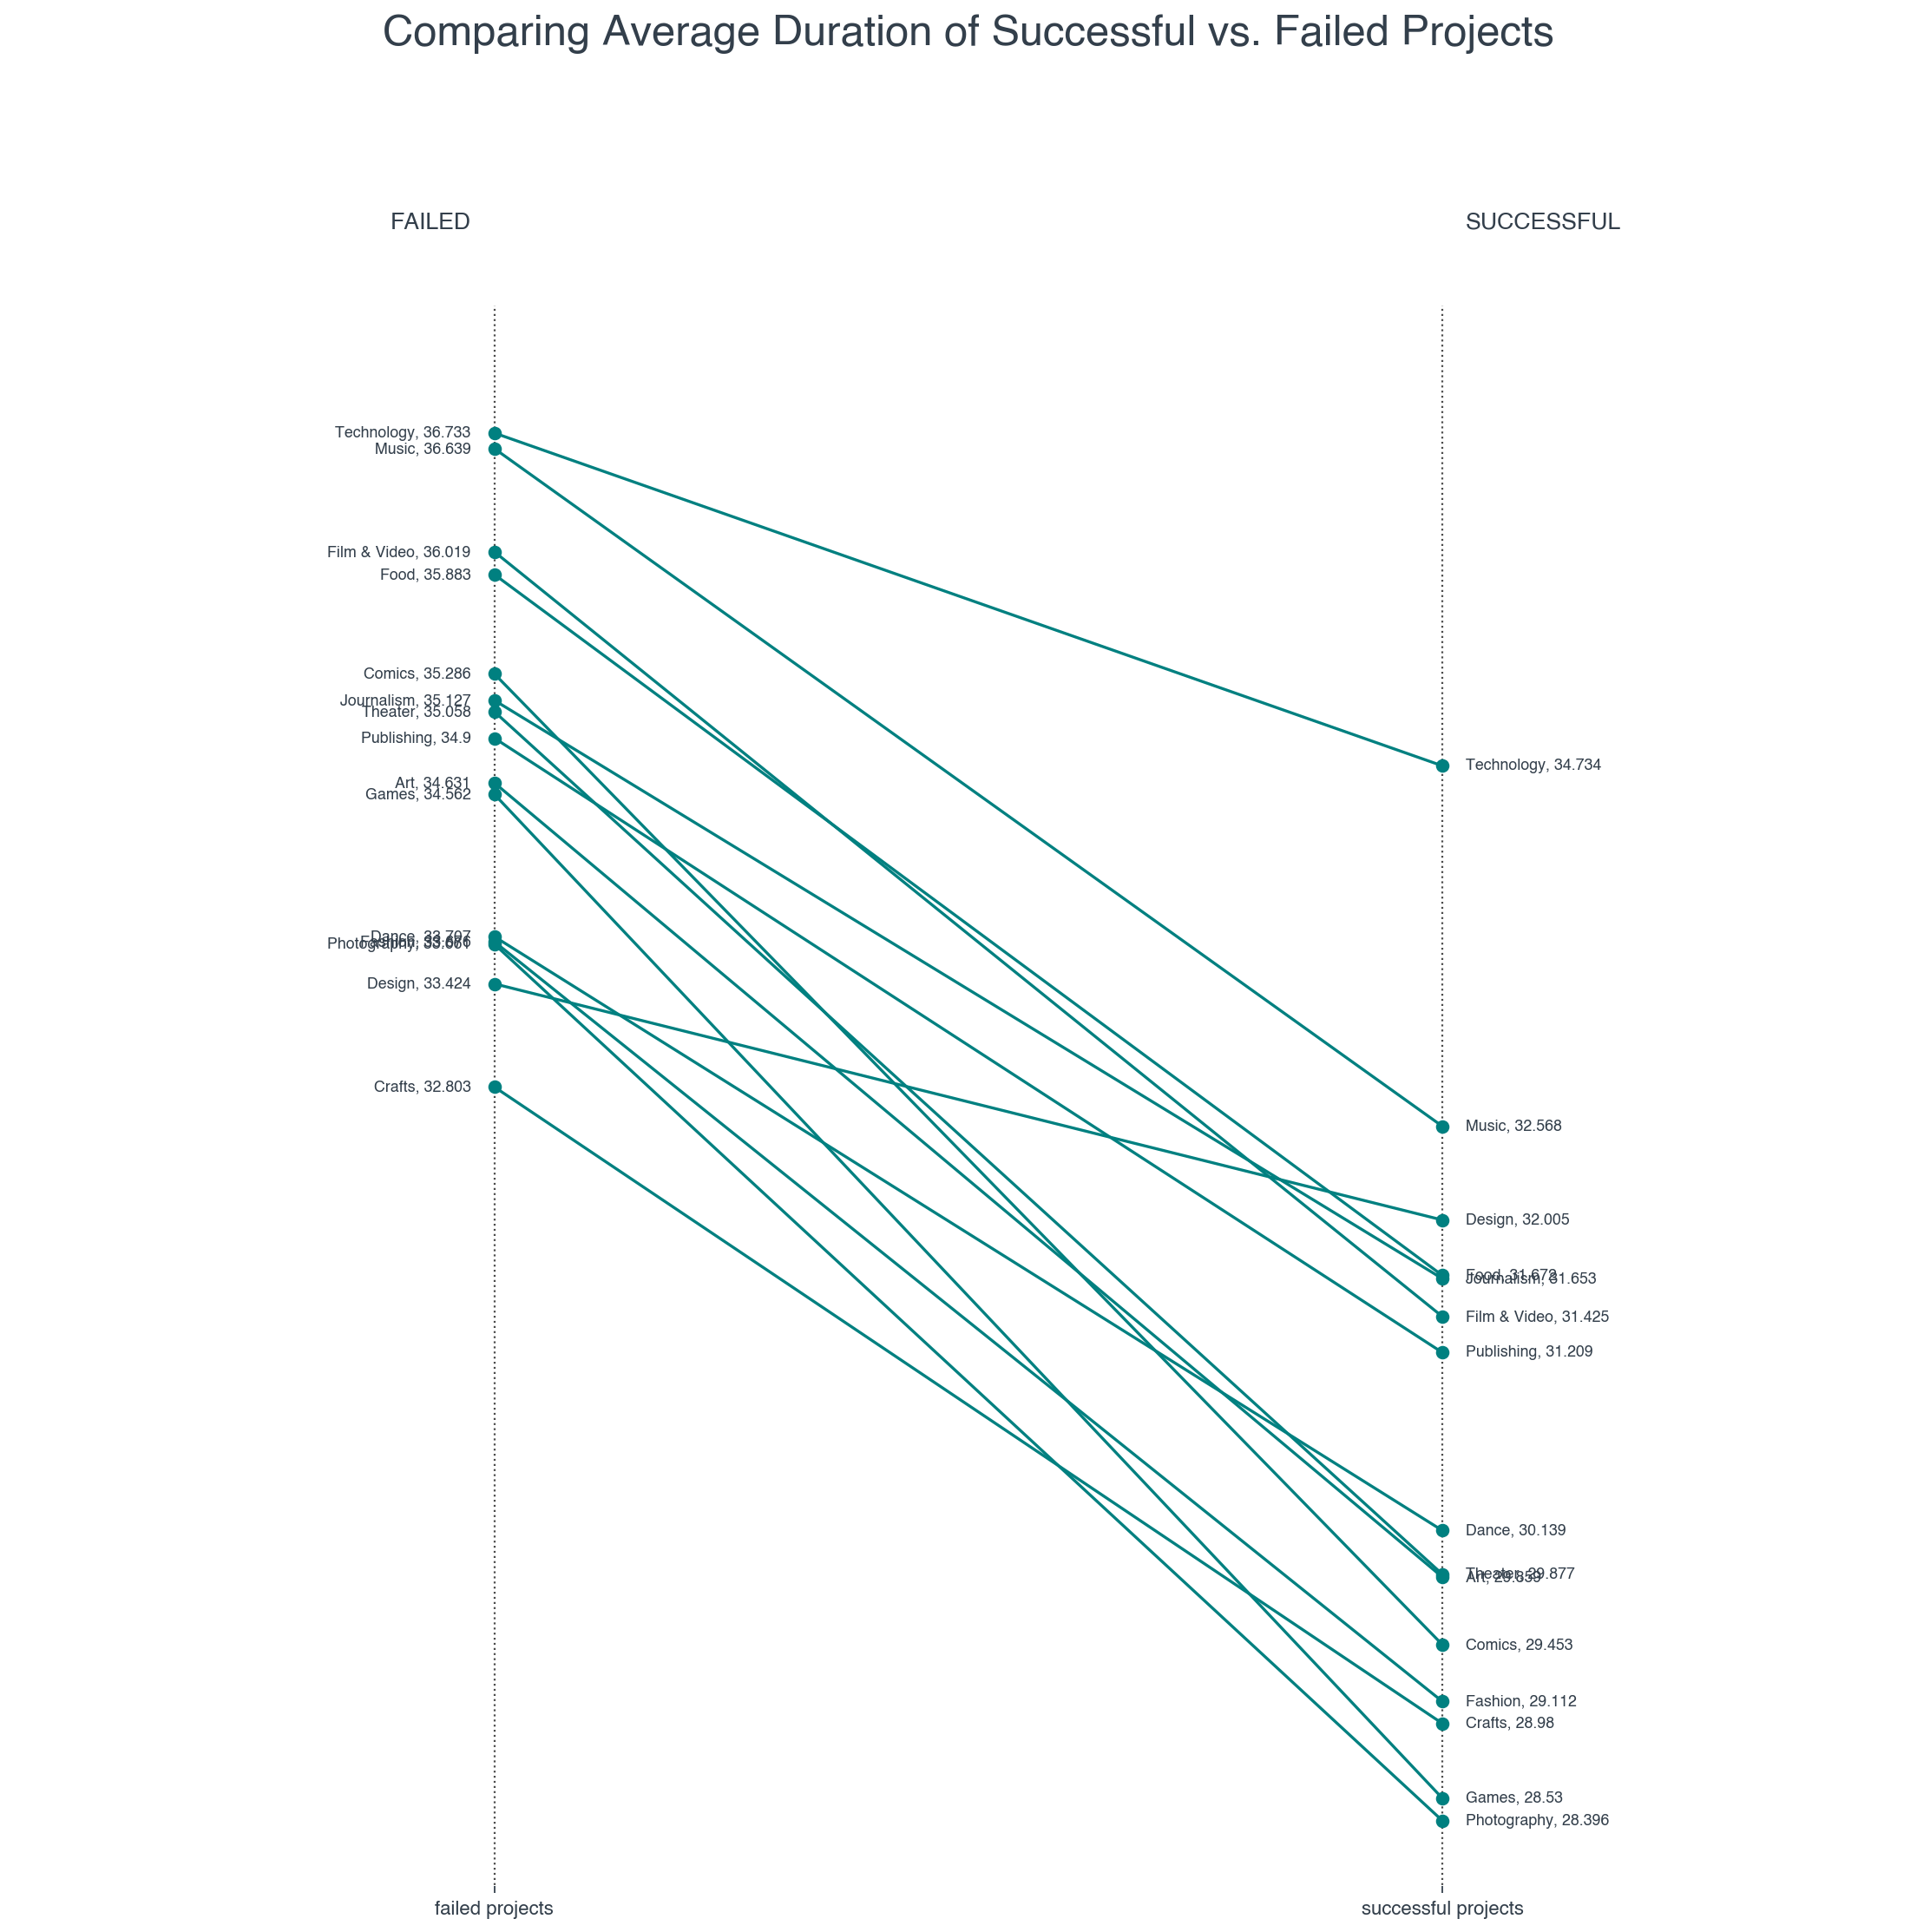

In [35]:
import matplotlib.lines as mlines

left_label = [str(c) + ', '+ str(y) for c, y in zip(cd_df.category, cd_df['duration_f'])]
right_label = [str(c) + ', '+ str(y) for c, y in zip(cd_df.category, cd_df['duration_s'])]
klass = ['red' if (y1-y2) < 0 else 'green' for y1,y2 in zip(cd_df['duration_f'], cd_df['duration_s'])]



def newline(p1,p2,color = 'black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]],[p1[1],p2[1]], color = 'teal' if p1[1]-p2[1] > 0 else 'green', marker = 'o', markersize = 6)
    ax.add_line(l)
    return l 

fig, ax = plt.subplots(1,1,figsize= (14,14), dpi=80)


ax.vlines(x=1, ymin=25, ymax=37.5, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=25, ymax=37.5, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

ax.scatter(y=cd_df['duration_f'], x=np.repeat(1, cd_df.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=cd_df['duration_s'], x=np.repeat(3, cd_df.shape[0]), s=10, color='black', alpha=0.7)

for p1, p2, c in zip(cd_df['duration_f'], cd_df['duration_s'], cd_df['category']):
    newline([1,p1], [3,p2])
    ax.text(1-0.05, p1, c + ', ' + str(round(p1,3)), horizontalalignment='right', verticalalignment='center', fontdict={'size':8})
    ax.text(3+0.05, p2, c + ', ' + str(round(p2,3)), horizontalalignment='left', verticalalignment='center', fontdict={'size':8})

ax.text(1-0.05, 38, 'FAILED', horizontalalignment='right', verticalalignment='center', fontdict={'size':12, 'weight':700})
ax.text(3+0.05, 38, 'SUCCESSFUL', horizontalalignment='left', verticalalignment='center', fontdict={'size':12, 'weight':700})

ax.set_title("Comparing Average Duration of Successful vs. Failed Projects", fontdict={'size':22})
ax.set(xlim=(0,4), ylim=(28,39), ylabel='Mean duration(days)')
ax.set_xticks([1,3])
ax.set_xticklabels(["failed projects", "successful projects"])
plt.yticks(np.arange(28.4, 36.8, 0.01))
ax.axes.yaxis.set_visible(False)

plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)
plt.tight_layout()
plt.show()


# Correlation

In [36]:
df_f

,id,name,country,backers_count,currency,deadline,goal,launched_at,pledged,project_state,category,sub_category,spotlight,duration,fr
0,1124922936,Palmetto Pork Skins,US,1,USD,1453922267,25000.0,1451330267,50.0,failed,Food,Food Trucks,False,30.000000,0.002000
6,1220123904,Millennial Challenge,US,1,USD,1462061160,3028.0,1459194568,1.0,failed,Photography,Nature,False,33.178148,0.000330
7,109249172,Slot Caddy,US,2,USD,1545144041,15000.0,1539956441,121.0,failed,Technology,Apps,False,60.041667,0.008067
9,532345676,GoalGetter,US,3,USD,1580998057,15000.0,1575814057,161.0,failed,Technology,Apps,False,60.000000,0.010733
10,1158508271,PEC.TV,US,11,USD,1426982640,5000.0,1421886624,607.0,failed,Technology,Camera Equipment,False,58.981667,0.121400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147889,1786107001,Notes of Hope-The Musical,US,0,USD,1440508016,20000.0,1437916016,0.0,failed,Theater,Musical,False,30.000000,0.000000
147891,1730970428,Pollen Hitchhiker,US,2,USD,1572761040,6000.0,1570677980,2.0,failed,Film & Video,Animation,False,24.109491,0.000333
147894,1825515543,Help Reveal Go Weekly,US,368,USD,1449772591,75000.0,1447180591,31627.5,failed,Journalism,Audio,False,30.000000,0.421700
147896,1566394390,"""Wizard Alchemy"" Poetry Gazette from Word Wiza...",US,0,USD,1448938926,88489.0,1446343326,0.0,failed,Publishing,Poetry,False,30.041667,0.000000


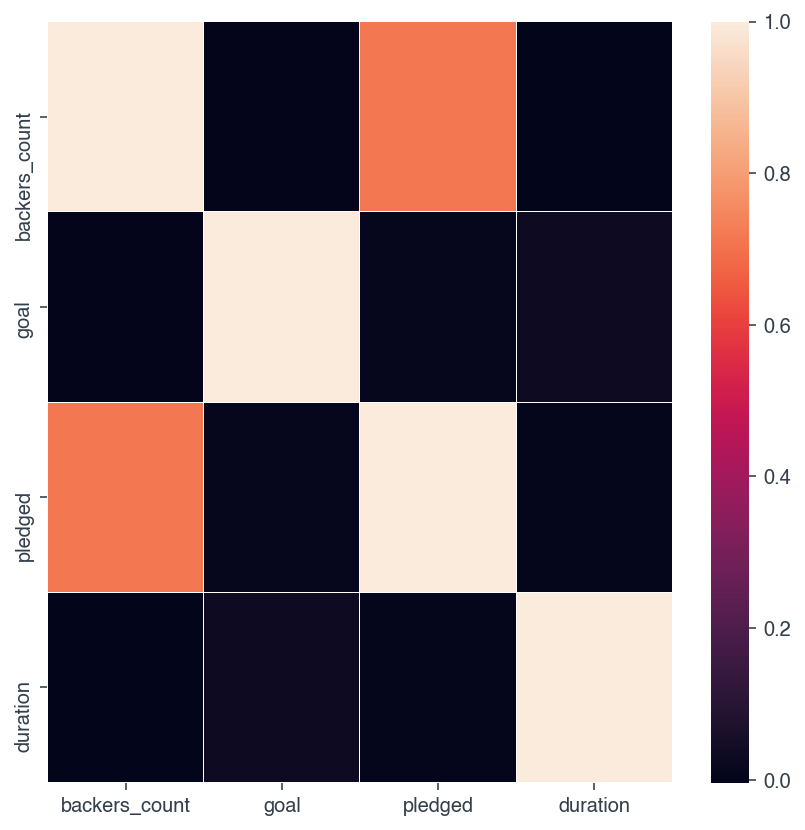

In [37]:
import seaborn as sns
def corr_plot(data, features, fig_size):

    corr=data[features].corr()
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            ax=ax, linewidths=0.01);

corr_plot(df_f, ['backers_count','goal', 'pledged', 'duration'], (7,7))



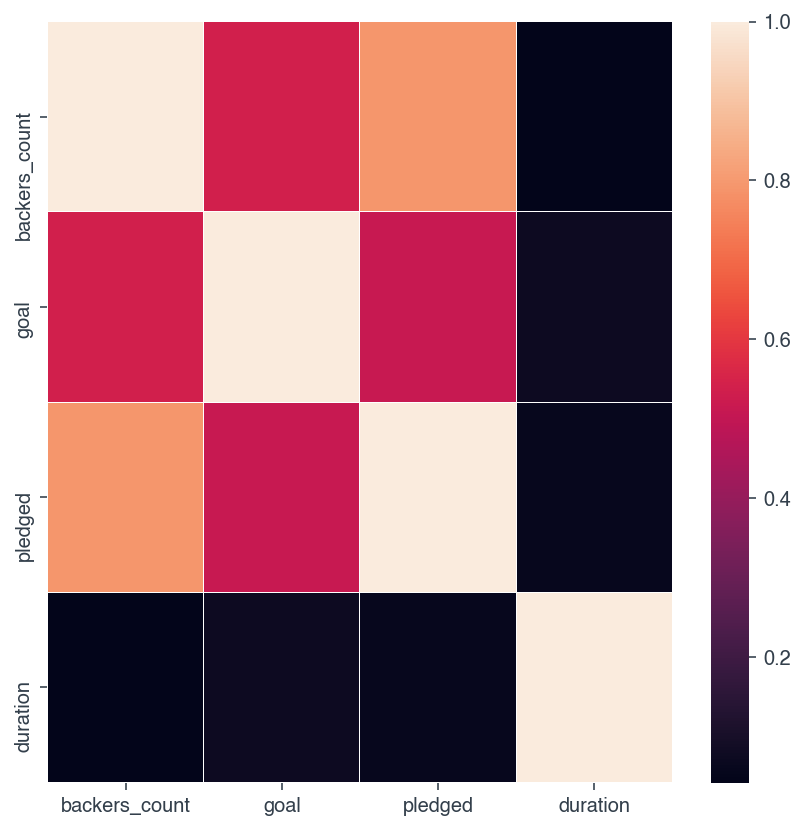

In [38]:
corr_plot(df_s, ['backers_count','goal', 'pledged', 'duration'], (7,7))


# CATEGORICAL ANALYSIS HYPOTHESIS 

In [39]:
failed_cat = df_f.groupby('category')[['backers_count','goal','pledged','duration']].mean().reset_index()
succ_cat = df_s.groupby('category')[['backers_count','goal','pledged','duration']].mean().reset_index()

In [40]:
failed_cat

,category,backers_count,goal,pledged,duration
0,Art,8.121556,52686.645215,576.056591,34.630584
1,Comics,30.437601,19526.777958,1492.792577,35.285816
2,Crafts,5.381974,14135.252048,354.578607,32.803312
3,Dance,8.087500,16153.364583,514.044688,33.706926
4,Design,17.163011,123595.305276,1385.380053,33.423519
5,Fashion,9.890226,25170.647569,903.378926,33.676055
6,Film & Video,14.208926,234508.868506,1480.598223,36.019167
7,Food,11.674591,52579.848845,992.955222,35.882713
8,Games,15.857704,106344.745339,1229.670702,34.561504
9,Journalism,7.614850,125673.350413,540.618120,35.126834


In [41]:
df_f['pledged'].sum()/df_f['backers_count'].sum()

89.2399285222761

In [42]:
df_s['pledged'].sum()/df_s['backers_count'].sum()

96.20270191191423

In [43]:
succ_cat

,category,backers_count,goal,pledged,duration
0,Art,98.860129,4300.072892,7629.041856,29.859296
1,Comics,282.733601,5659.052687,14402.227973,29.453357
2,Crafts,81.310969,3181.228967,5760.129404,28.979617
3,Dance,67.687576,5491.038977,6140.069013,30.139093
4,Design,863.555168,10635.542803,92419.462311,32.004677
5,Fashion,197.575644,6491.968204,19650.318685,29.111934
6,Film & Video,200.555939,14464.123242,19639.521036,31.424867
7,Food,170.920175,12946.559211,17088.312746,31.672057
8,Games,833.863537,14854.596980,61644.932058,28.530466
9,Journalism,182.807554,9602.715827,12769.220701,31.652741


# Hypothesis Testing

$H_0 =$ Average FR of projects between Music and Technology are the same.

               vs 

$H_A =$ Average FR of projects between Music and Technology are different.

In [44]:
df_s

,id,name,country,backers_count,currency,deadline,goal,launched_at,pledged,project_state,category,sub_category,spotlight,duration,fr
1,2077771673,Eat Shit: A Memorial Pin Campaign,US,11,USD,1575075016,250.0,1572479416,253.00,successful,Fashion,Accessories,True,30.041667,1.012000
2,2008689997,TRIC Clothing Co.,US,50,USD,1604171238,4000.0,1601579238,4475.00,successful,Fashion,Apparel,True,30.000000,1.118750
3,409339132,Vindictive,US,2,USD,1472663760,600.0,1471054707,662.00,successful,Comics,Graphic Novels,True,18.623299,1.103333
4,1789057014,Wooden HEZ's Southern HEZpitality Tour 2013,US,10,USD,1365875128,600.0,1363283128,601.43,successful,Music,Rock,True,30.000000,1.002383
5,1526272731,Mountain Stationery,US,24,USD,1607057940,100.0,1604542278,1087.00,successful,Crafts,Stationery,True,29.116458,10.870000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147890,1382374386,Hound & Hammer,US,236,USD,1474150778,25000.0,1471558778,32036.00,successful,Fashion,Footwear,True,30.000000,1.281440
147892,353159547,REAXT | Quality Speaker. Affordable Price Tag.,US,334,USD,1602163045,20000.0,1597151845,79684.00,successful,Technology,Sound,True,58.000000,3.984200
147893,1193073262,The Werewolves of Hollywood Blvd: A Damnable R...,US,60,USD,1403205170,5500.0,1400613170,5565.00,successful,Theater,Musical,True,30.000000,1.011818
147895,1418520966,NASCAR at the Valentine Richmond History Center,US,21,USD,1399825596,1000.0,1394641596,1201.00,successful,Art,Public Art,True,60.000000,1.201000


In [45]:
#all states
music_fr = list(df[df['category'] == 'Music']['fr'])
tech_fr = list(df[df['category'] == 'Technology']['fr'])
#successful only 
s_music_fr = list(df_s[df_s['category'] == 'Music']['fr'])
s_tech_fr = list(df_s[df_s['category'] == 'Technology']['fr'])
#Failed only 
f_music_fr = list(df_f[df_f['category'] == 'Music']['fr'])
f_tech_fr = list(df_f[df_f['category'] == 'Technology']['fr'])

In [46]:
music_fr_mean = np.mean(music_fr)
tech_fr_mean = np.mean(tech_fr)
#success
s_music_fr_mean = np.mean(s_music_fr)
s_tech_fr_mean = np.mean(s_tech_fr)
#fail 
f_music_fr_mean = np.mean(f_music_fr)
f_tech_fr_mean = np.mean(f_tech_fr)

print("ALL: Music = {}, tech = {}".format(music_fr_mean,tech_fr_mean))
print("SUCCESSFUL: Music = {}, tech = {}".format(s_music_fr_mean,s_tech_fr_mean))
print("FAILED: Music = {}, tech = {}".format(f_music_fr_mean,f_tech_fr_mean))


ALL: Music = 9.075649462995703, tech = 6.568265674054254
SUCCESSFUL: Music = 13.147783736138585, tech = 14.12457452154307
FAILED: Music = 0.0766792178041879, tech = 0.07801259266933255


In [47]:
stats.describe(music_fr)

DescribeResult(nobs=21796, minmax=(0.0, 68764.1), mean=9.075649462995703, variance=242527.2656925831, skewness=126.33768553403536, kurtosis=17452.59777619589)

In [109]:
stats.describe(f_tech_fr)

DescribeResult(nobs=6061, minmax=(0.0, 3.102), mean=0.07801259266933255, variance=0.02430498384723642, skewness=3.7957793634261696, kurtosis=30.736194623027103)

In [110]:
stats.describe(f_music_fr)

DescribeResult(nobs=6213, minmax=(0.0, 1.00087), mean=0.0766792178041879, variance=0.019905730926146517, skewness=2.5834281821964713, kurtosis=7.331303643544658)

In [50]:
stats.describe(tech_fr)

DescribeResult(nobs=13043, minmax=(0.0, 22603.0), mean=6.568265674054254, variance=49865.37256252102, skewness=87.31149018859074, kurtosis=8347.721878707813)

In [51]:
print(stats.ttest_ind(music_fr,tech_fr,equal_var=False))
print(stats.ttest_ind(s_music_fr,s_tech_fr,equal_var=False))
print(stats.ttest_ind(f_music_fr,f_tech_fr))

Ttest_indResult(statistic=0.6484789653944186, pvalue=0.5166797425617294)
Ttest_indResult(statistic=-0.15115726497134185, pvalue=0.8798532822792247)
Ttest_indResult(statistic=-0.4970511096609707, pvalue=0.619161914334281)


In [112]:
stats.ttest_ind(f_music_fr,f_tech_fr)

Ttest_indResult(statistic=-0.4970511096609707, pvalue=0.619161914334281)